In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\adolp\AppData\Local\Temp\ipykernel_29488\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [8]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [9]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print("Most Recent Date in the Dataset:", most_recent_date)

Most Recent Date in the Dataset: 2017-08-23


Most Recent Date in the Dataset: 2017-08-23
Date One Year Ago: 2016-08-23 00:00:00
           Date  Precipitation
0    2016-08-24           0.08
1006 2016-08-24            NaN
1524 2016-08-24           2.15
702  2016-08-24           2.28
360  2016-08-24           2.15


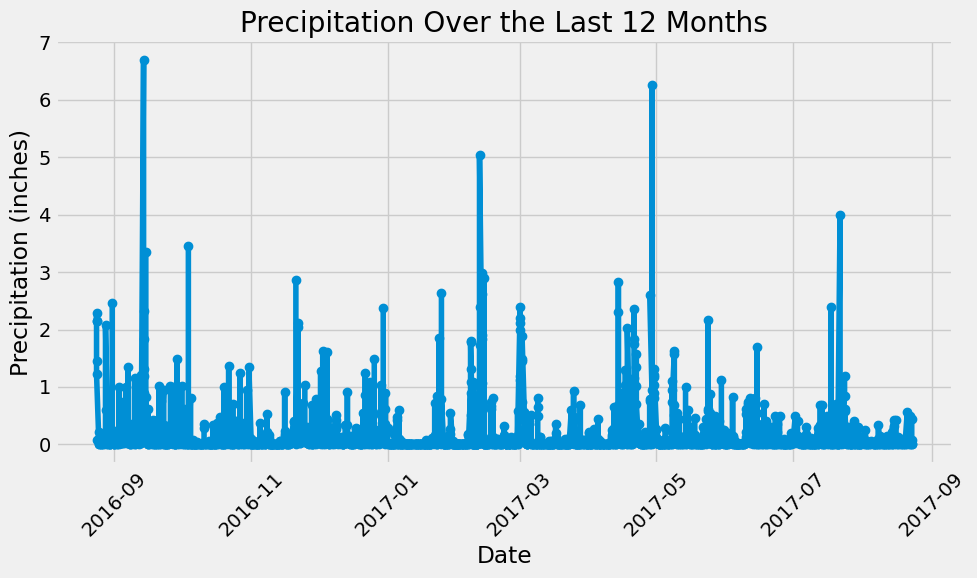

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print("Most Recent Date in the Dataset:", most_recent_date)
# Calculate the date one year from the last date in data set.
from datetime import datetime, timedelta

most_recent_datetime = datetime.strptime(most_recent_date, "%Y-%m-%d")
one_year_ago = most_recent_datetime - timedelta(days=365)
print("Date One Year Ago:", one_year_ago)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'])
precipitation_df.sort_values('Date', inplace=True)
print(precipitation_df.head())
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.plot(precipitation_df['Date'], precipitation_df['Precipitation'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Over the Last 12 Months')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df['Precipitation'].describe()

print("Summary Statistics for Precipitation Data:")
print(precipitation_summary)

Summary Statistics for Precipitation Data:
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print("Total Number of Stations in the Dataset:", total_stations)

Total Number of Stations in the Dataset: 9


In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(
    Measurement.station, 
    func.count(Measurement.station).label('count')
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# Display the station and their counts 
print("Most Active Stations and Their Counts:")
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Most Active Stations and Their Counts:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Find the most active station ID
most_active_station_id = active_stations[0][0]  # The first result from the previous query
print("Most Active Station ID:", most_active_station_id)

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs).label('Min Temp'),
    func.max(Measurement.tobs).label('Max Temp'),
    func.avg(Measurement.tobs).label('Avg Temp')
).filter(Measurement.station == most_active_station_id).all()

# Extract and display the results
min_temp, max_temp, avg_temp = temperature_stats[0]
print(f"Temperature Statistics for Station {most_active_station_id}:")
print(f"Lowest Temperature: {min_temp}°F")
print(f"Highest Temperature: {max_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")


Most Active Station ID: USC00519281
Temperature Statistics for Station USC00519281:
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


Most Active Station ID: USC00519281
         Date  Temperature
0  2016-08-24         77.0
1  2016-08-25         80.0
2  2016-08-26         80.0
3  2016-08-27         75.0
4  2016-08-28         73.0


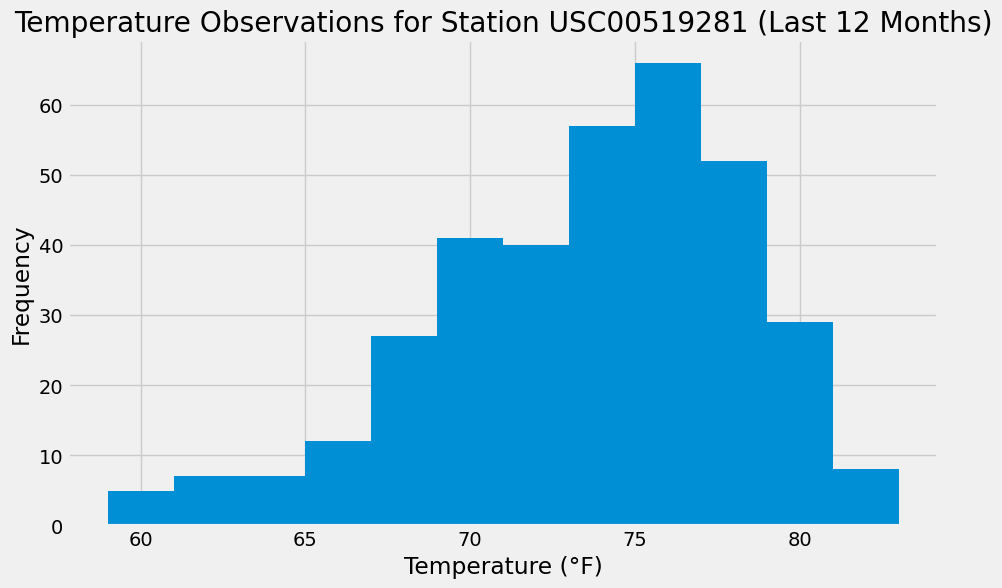

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Step 1: Identify the Most Active Station ID
most_active_station_id = active_stations[0][0]  # The first result from the previous query
print("Most Active Station ID:", most_active_station_id)

# Step 2: Calculate the Date One Year Ago from the Most Recent Date
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_datetime = datetime.strptime(most_recent_date, "%Y-%m-%d")
one_year_ago = most_recent_datetime - timedelta(days=365)

# Step 3: Query the Last 12 Months of Temperature Observation Data for the Most Active Station
temperature_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).all()

# Step 4: Save the Query Results to a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])

# Display the DataFrame to verify the data
print(temperature_df.head())

# Step 5: Plot the Temperature Observations as a Histogram
plt.figure(figsize=(10, 6))
temperature_df['Temperature'].plot(kind='hist', bins=12)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station {most_active_station_id} (Last 12 Months)')
plt.grid(True)
plt.show()


# Close Session

In [18]:
# Close Session
session.close()